<a href="https://colab.research.google.com/github/yeswhos/COMP5623-AI/blob/master/CW2/COMP5623_CW2_Fanhui.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP5623 Coursework on Image Caption Generation

Starter code.



## Text preparation 

We need to build a vocabulary.

In [61]:
# Mounted Drive if using Colab; otherwise, your local path
from google.colab import drive
drive.mount('/content/drive')
root = "drive/My Drive/Colab Notebooks/data/Flickr8k/" # <--- replace this with your root data directory
caption_dir = root + "captions/"                       # <--- replace these too
image_dir = root + "images/"                           # <---

token_file = "Flickr8k.token.txt"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
import os

os.listdir(root)

['captions', 'images']

In [63]:
caption_dir

'drive/My Drive/Colab Notebooks/data/Flickr8k/captions/'

A helper function to read in our ground truth text file.

In [0]:
def read_lines(filepath):
    """ Open the ground truth captions into memory, line by line. """
    file = open(filepath, 'r')
    lines = []

    while True: 
        # Get next line from file until there's no more
        line = file.readline() 
        if not line: 
            break
        lines.append(line.strip())
    file.close() 
    return lines

You can read all the ground truth captions (5 per image), into memory as follows:

In [0]:
lines = read_lines(caption_dir + token_file)

In [66]:
lines[:10]

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .',
 '1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .',
 '1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .',
 '1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .']

In [0]:
class Vocabulary(object):
    """Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # Intially, set both the IDs and words to empty dictionaries.
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        # If the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            # print("#######")
            # print(word)
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            #print(self.word2idx)
            # Increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # If we try to access a word in the dictionary which does not exist, return the <unk> id
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

Extract all the words from ```lines```, and create a list of them in a variable ```words```, for example:

```words = ["a", "an", "the", "cat"... ]```

No need to worry about duplicates.


# Build the vocabulary.

In [0]:
# Create a vocab instance
vocab = Vocabulary()

# Add the token words first
vocab.add_word('<pad>')
vocab.add_word('<start>')
vocab.add_word('<end>')
vocab.add_word('<unk>')

Add the rest of the words from the parsed captions:

``` vocab.add_word('new_word')```

Don't add words that appear three times or less.

# 筛选掉出现字数小于4的单词，然后放到list2里面

In [0]:
words = []
j = 0
for i in range(1, 40460):
  str_1 = "".join(lines[j:i])
  str_new_1 = str_1[28:]
  words.append(str_new_1)
  j += 1


In [74]:
counts = {}#创建一个空的字典
for i in range(0, len(words)):
    str_2 = "".join(words[i])
    str_2 = str_2.lower()
    words1 = str_2.split()
    #print(words)
    for word in words1:
        counts[word] = counts.get(word,0)+1
    #print(counts)
    items_1 = list(counts.items())#将字典中的每对键值对看做一个元素存入items列表中
    # items.sort(key=lambda x:x[1],reverse=True)
    #根据lambda表达式来进行排序 在这里是根据数字来排序
list2 = []
for i in range(len(items_1)):
    word,count = items_1[i]
    if (count > 3) & (word != '.') & (word != ','):
        list2.append(word)
print(len(list2))
print(list2)

TypeError: ignored

# 有了list2，就能放到vocab里面了，所以长度是3488个

In [0]:
for i in range(0, len(list2)):
  vocab.add_word(list2[i])

In [0]:
vocab.__len__()

## Dataset and loaders for training

Keeping the same order, concatenate all the cleaned words from each caption into a string again, and add them all to a list of strings ```cleaned_captions```. Store all the image ids in a list ```image_ids```.

image ids

In [0]:
image_ids = []
j = 0
for i in range(1, 40460):
# for i in range(1, 5):
  str_3 = "".join(lines[j:i])
  str_new_2 = str_3.split(".")
  image_ids.append(str_new_2[0])
  j += 1
  if str_new_2[0] == '2258277193_586949ec62':
    print("here")
#print(image_ids)

cleaned captions

In [0]:
cleaned_captions = []

j = 0
for i in range(1, 40460):
  tmp = []
  str_4 = "".join(lines[j:i])
  str_4 = str_4.lower()
  #str = lines[:i]
  str_new_3 = str_4[28:].split(" ")
  for word in str_new_3:
    if word in list2:
      tmp.append(word)
  cleaned_captions.append(tmp)
  str_new_3 = ""
  j += 1
print(len(cleaned_captions))
#print(cleaned_captions[:5])

In [0]:

str_5 = []
for i in range(0, 40459):
  string = ' '.join(cleaned_captions[i])
  str_5.append(string)
  string = ''
print(str_5)
print(len(str_5))

The dataframe for the image paths and captions.

In [0]:
import pandas as pd

data = {
    'image_id': image_ids,
    'path': [image_dir + image_id + ".jpg" for image_id in image_ids],
    'caption': str_5
}

data_df = pd.DataFrame(data, columns=['image_id', 'path', 'caption'])

In [0]:
data_df.head(n=5)

In [0]:
# data_df['path']
# data_df.iloc[0,2]
caption = data_df['caption'][2]
caption

This is the Flickr8k class for the dataset.

In [0]:
from PIL import Image
import cv2
from nltk import tokenize
from torch.utils.data import Dataset

class Flickr8k(Dataset):
    """ Flickr8k custom dataset compatible with torch.utils.data.DataLoader. """
    
    def __init__(self, df, vocab, transform=None):
        """ Set the path for images, captions and vocabulary wrapper.
        
        Args:
            df: df containing image paths and captions.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.df = df
        self.vocab = vocab
        self.transform = transform

    def __getitem__(self, index):
        """ Returns one data pair (image and caption). """

        vocab = self.vocab

        caption = self.df['caption'][index]
        img_id = self.df['image_id'][index]
        path = self.df['path'][index]

        image = Image.open(open(path, 'rb'))

        if self.transform is not None:
            image = self.transform(image)

        # Convert caption (string) to word ids.
        tokens = caption.split()
        caption = []
        # Build the Tensor version of the caption, with token words
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.df)

We need to overwrite the default PyTorch ```collate_fn()``` because our ground truth captions are sequential data of varying lengths. The default ```collate_fn()``` does not support merging the captions with padding.

You can read more about it here: https://pytorch.org/docs/stable/data.html#dataloader-collate-fn. 

In [0]:
def caption_collate_fn(data):
    """ Creates mini-batch tensors from the list of tuples (image, caption).
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length from longest to shortest.
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths

Now we define the data transform.

In [0]:
from torchvision import transforms

# Crop size matches the input dimensions expected by the pre-trained ResNet
data_transform = transforms.Compose([ 
    transforms.Resize(224),
    transforms.CenterCrop(224),  # Why do we choose 224 x 224?
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),   # Using ImageNet norms
                         (0.229, 0.224, 0.225))])

Initialising the datasets. The only twist is that every image has 5 ground truth captions, so each image appears five times in the dataframe. We don't want an image to appear in more than one set.

In [0]:
unit_size = 5

train_split = 0.95 # Defines the ratio of train/test data.

# We didn't shuffle the dataframe yet so this works
train_size = unit_size * round(len(data_df)*train_split / unit_size)

dataset_train = Flickr8k(
    df=data_df[:train_size].reset_index(drop=True),
    vocab=vocab,
    transform=data_transform,
)

dataset_test = Flickr8k(
    df=data_df[(train_size):].reset_index(drop=True),
    vocab=vocab,
    transform=data_transform,
)

Write the dataloaders ```train_loader``` and ```test_loader``` - explicitly replacing the collate_fn:

```train_loader = torch.utils.data.DataLoader(
  ...,
  collate_fn=caption_collate_fn
)```

Set train batch size to 128 and be sure to set ```shuffle=True```

In [0]:
import torch
train_loader = torch.utils.data.DataLoader(
    dataset_train,
    collate_fn = caption_collate_fn,
    batch_size=128,
    shuffle=True,
    num_workers = 2
)

test_loader = torch.utils.data.DataLoader(
    dataset_test,
    collate_fn = caption_collate_fn,
    batch_size=5,
    shuffle=True,
    num_workers=2
)

# valid_loader = torch.utils.data.DataLoader(
#     ins_dataset_valid,
#     batch_size=24,
#     shuffle=True,
#     num_workers=2
# )

## Encoder and decoder models

In [0]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True) # Pre-trained on ImageNet by default
        layers = list(resnet.children())[:-1]      # Keep all layers except the last one
        # Unpack the layers and create a new Sequential
        self.resnet = nn.Sequential(*layers)
        
        # We want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last fc layer (dimensions 1 x 1000)
        # into a Linear layer to resize
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        
        # Batch normalisation helps to speed up training
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        #encoder.eval() 
        """Extract feature vectors from input images."""
        with torch.no_grad():
          features = self.resnet(images)
        #features = Variable(features.data)
        features = features.view(features.size(0), -1)
        features = self.bn(self.linear(features))
        
        # Complete graph here. Remember to put the ResNet layer in a with torch.no_grad() block
        
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        
        # What is an embedding layer?
        self.embed = nn.Embedding(vocab_size, embed_size)

        # Define this layer (one at a time)
        #self.lstm / self.rnn
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)

        #RNN layer
        # self.rnn = nn.RNN(
        #     embed_size, 
        #     hidden_size, 
        #     num_layers = 1,
        #     batch_first = True
        # )
        
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        # What is "packing" a padded sequence?
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 

        hiddens, _ = self.lstm(packed) # Replace with self.rnn when using RNN
        #hiddens,_ = self.rnn(packed)

        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            #hiddens, states = self.rnn(inputs, states)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [0]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

Set training parameters.

In [0]:
embed_size = 256
hidden_size = 512
num_layers = 1
learning_rate = 0.001
num_epochs = 5
log_step = 10
save_step = 1

Initialize the models and set the learning parameters.

In [60]:
import numpy as np

# Build the models
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

# Optimisation will be on the parameters of BOTH the enocder and decoder,
# but excluding the ResNet parameters, only the new added layers.
params = list(
    decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters()
)

optimizer = torch.optim.Adam(params, lr=learning_rate)


TypeError: ignored

### Training the model

# Useless imshow method, ignore it

In [0]:
def show_from_tensor(tensor, title=None):
    img = tensor.clone()
    img = tensor.cpu().numpy()
    #img = tensor_to_np(img)
    plt.figure()
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [0]:
# img = torchvision.utils.make_grid(dataset_train[6][0]).numpy()
# plt.imshow(np.transpose(img,(1,2,0)))
# plt.show()


# Show image as well as captions

initial image

In [0]:
import matplotlib.pyplot as plt 
# import torchvision.datasets as dset
# import torchvision.transforms as transforms
# import torchvision
# import numpy as np

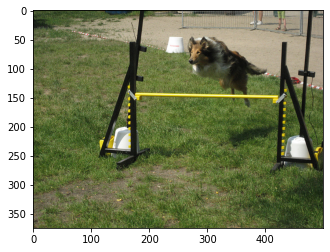

In [32]:
def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image
# path = 'drive/My Drive/Colab Notebooks/data/Flickr8k/images/1000268201_693b08cb0e.jpg'
path = dataset_test.df.iloc[0, 1] 
image = load_image(path, data_transform)
image_tensor = image.to(device)
# image = Image.open('drive/My Drive/Colab Notebooks/data/Flickr8k/images/1000268201_693b08cb0e.jpg')
image = Image.open(path)
plt.imshow(np.asarray(image))


initial captions

In [33]:
captions_sum = []
for i in range(0, 5):
  captions1 = dataset_test.df.iloc[i,2]
  captions_sum.append(captions1)
  print(captions1)
print(captions_sum)

brown and white sheltie leaping over a rail
collie is running through an obstacle course
ollie jumping over a training hurdle that is on the grass
ollie making a jump over a yellow hurdle
he dog is leaping over a hurdle
['brown and white sheltie leaping over a rail', 'collie is running through an obstacle course', 'ollie jumping over a training hurdle that is on the grass', 'ollie making a jump over a yellow hurdle', 'he dog is leaping over a hurdle']


multicolor little beard used try fencing jeeps feild navigating caution seashore littered classic mound wigs lies many pumps line peering


The loop to train the model. Feel free to put this in a function if you prefer.

In [0]:
# Train the models
total_step = len(train_loader)
for epoch in range(num_epochs):
    #generate_captions()
    for i, (images, captions, lengths) in enumerate(train_loader):

        # Set mini-batch dataset
        images = images.to(device)
        captions = captions.to(device)
        
        # Packed as well as we'll compare to the decoder outputs
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
        
        # Forward, backward and optimize
        features = encoder(images)
        outputs = decoder(features, captions, lengths)

        loss = criterion(outputs, targets)
        
        # Zero gradients for both networks
        decoder.zero_grad()
        encoder.zero_grad()

        loss.backward()
        optimizer.step()

        # Print log info
        if i % log_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch, num_epochs, i, total_step, loss.item())) 

        # If you want to save the model checkpoints - recommended once you have everything working
        # Make sure to save RNN and LSTM versions separately

        if (i+1) % save_step == 0:
          torch.save(decoder.state_dict(), './drive/My Drive/decoder-{}.ckpt'.format(epoch+1))
          torch.save(encoder.state_dict(), './drive/My Drive/encoder-{}.ckpt'.format(epoch+1))

Epoch [0/5], Step [0/301], Loss: 8.1762
Epoch [0/5], Step [10/301], Loss: 4.7925
Epoch [0/5], Step [20/301], Loss: 4.6122
Epoch [0/5], Step [30/301], Loss: 4.3885
Epoch [0/5], Step [40/301], Loss: 4.1804
Epoch [0/5], Step [50/301], Loss: 3.9240
Epoch [0/5], Step [60/301], Loss: 3.8872
Epoch [0/5], Step [70/301], Loss: 3.9520
Epoch [0/5], Step [80/301], Loss: 3.6609
Epoch [0/5], Step [90/301], Loss: 3.8467
Epoch [0/5], Step [100/301], Loss: 3.7925
Epoch [0/5], Step [110/301], Loss: 3.5129
Epoch [0/5], Step [120/301], Loss: 3.6483
Epoch [0/5], Step [130/301], Loss: 3.4647
Epoch [0/5], Step [140/301], Loss: 3.4860
Epoch [0/5], Step [150/301], Loss: 3.4953
Epoch [0/5], Step [160/301], Loss: 3.3222
Epoch [0/5], Step [170/301], Loss: 3.4668
Epoch [0/5], Step [180/301], Loss: 3.4456
Epoch [0/5], Step [190/301], Loss: 3.4898
Epoch [0/5], Step [200/301], Loss: 3.3893
Epoch [0/5], Step [210/301], Loss: 3.1456
Epoch [0/5], Step [220/301], Loss: 3.2617
Epoch [0/5], Step [230/301], Loss: 3.3105
Epo

In [0]:
generated_captions = []

def generated(encoder, decoder):
  feature = encoder(image_tensor)
  
  sampled_ids = decoder.sample(feature)
  sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)

  # Convert word_ids to words
  sampled_caption = []
  # counter = 1
  for word_id in sampled_ids:
    word = vocab.idx2word[word_id]
    if (word != '<start>') & (word != '<end>') :
      
      sampled_caption.append(word)
    if word == '<end>':
          break
    # print('{} epoch '.format(counter), word)
    # counter += 1
  sentence = ' '.join(sampled_caption)
  generated_captions.append(sentence)
  print(sentence)
  

In [48]:
the_model_encoder = EncoderCNN(embed_size).eval()
the_model_decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers)
the_model_encoder = the_model_encoder.to(device)
the_model_decoder = the_model_decoder.to(device)

the_model_encoder.load_state_dict(torch.load('./drive/My Drive/encoder-1.ckpt'))
the_model_decoder.load_state_dict(torch.load('./drive/My Drive/decoder-1.ckpt')) 
generated(the_model_encoder, the_model_decoder)
the_model_encoder.load_state_dict(torch.load('./drive/My Drive/encoder-2.ckpt'))
the_model_decoder.load_state_dict(torch.load('./drive/My Drive/decoder-2.ckpt')) 
generated(the_model_encoder, the_model_decoder)
the_model_encoder.load_state_dict(torch.load('./drive/My Drive/encoder-3.ckpt'))
the_model_decoder.load_state_dict(torch.load('./drive/My Drive/decoder-3.ckpt')) 
generated(the_model_encoder, the_model_decoder)
the_model_encoder.load_state_dict(torch.load('./drive/My Drive/encoder-4.ckpt'))
the_model_decoder.load_state_dict(torch.load('./drive/My Drive/decoder-4.ckpt')) 
generated(the_model_encoder, the_model_decoder)
the_model_encoder.load_state_dict(torch.load('./drive/My Drive/encoder-5.ckpt'))
the_model_decoder.load_state_dict(torch.load('./drive/My Drive/decoder-5.ckpt')) 
generated(the_model_encoder, the_model_decoder)

a dog is running through the snow
a dog is running through the grass
a dog is jumping over a hurdle
a dog jumps over a hurdle
a dog is jumping over a hurdle


In [56]:
the_model_encoder_lstm = EncoderCNN(embed_size).eval()
the_model_decoder_lstm = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers)
the_model_encoder_lstm = the_model_encoder_lstm.to(device)
the_model_decoder_lstm = the_model_decoder_lstm.to(device)

the_model_encoder_lstm.load_state_dict(torch.load('./drive/My Drive/encoder_lstm-1.ckpt'))
the_model_decoder_lstm.load_state_dict(torch.load('./drive/My Drive/decoder_lstm-1.ckpt')) 
generated(the_model_encoder_lstm, the_model_decoder_lstm)
the_model_encoder_lstm.load_state_dict(torch.load('./drive/My Drive/encoder_lstm-2.ckpt'))
the_model_decoder_lstm.load_state_dict(torch.load('./drive/My Drive/decoder_lstm-2.ckpt')) 
generated(the_model_encoder_lstm, the_model_decoder_lstm)
the_model_encoder_lstm.load_state_dict(torch.load('./drive/My Drive/encoder_lstm-3.ckpt'))
the_model_decoder_lstm.load_state_dict(torch.load('./drive/My Drive/decoder_lstm-3.ckpt')) 
generated(the_model_encoder_lstm, the_model_decoder_lstm)
the_model_encoder_lstm.load_state_dict(torch.load('./drive/My Drive/encoder_lstm-4.ckpt'))
the_model_decoder_lstm.load_state_dict(torch.load('./drive/My Drive/decoder_lstm-4.ckpt')) 
generated(the_model_encoder_lstm, the_model_decoder_lstm)
the_model_encoder_lstm.load_state_dict(torch.load('./drive/My Drive/encoder_lstm-5.ckpt'))
the_model_decoder_lstm.load_state_dict(torch.load('./drive/My Drive/decoder_lstm-5.ckpt')) 
generated(the_model_encoder_lstm, the_model_decoder_lstm)

NameError: ignored

In [49]:
counter = 1
for each in generated_captions:
  print('{} epoch:'.format(counter), each)
  counter += 1


1 epoch: a dog is running through the snow
2 epoch: a dog is running through the grass
3 epoch: a dog is jumping over a hurdle
4 epoch: a dog jumps over a hurdle
5 epoch: a dog is jumping over a hurdle


a dog is jumping over a hurdle


a dog jumps over a hurdle


a dog is jumping over a hurdle


In [0]:
generated_captions

['a dog is running through the snow',
 'a dog is running through the grass',
 'a dog is jumping over a hurdle',
 'a dog jumps over a hurdle',
 'a dog is jumping over a hurdle']

In [51]:
from nltk.translate.bleu_score import sentence_bleu
reference = captions_sum
list_score = []
counter = 1
for list in generated_captions:

  candidate = list
  score = sentence_bleu(reference, candidate)
  list_score.append(score)
  print('{} epoch:'.format(counter), score)
  counter += 1

1 epoch: 0.8811449934416968
2 epoch: 0.9521396682078629
3 epoch: 0.9219114647198714
4 epoch: 0.6742517133408039
5 epoch: 0.9219114647198714


TypeError: ignored

In [0]:
BLEU评估测试

In [0]:
from nltk.translate.bleu_score import sentence_bleu
reference = [['this', 'is', 'a', 'test'], ['this', 'is' 'test']]
candidate = ['this', 'is', 'a', 'test']
score = sentence_bleu(reference, candidate)
print(score)

1.0


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
